## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [189]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [190]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join([t.lower() for t in text])
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


#### Data loading: "Евгений Онегин"


In [183]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-04-19 17:32:57--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.04s   

2021-04-19 17:32:57 (6.86 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [191]:
# Join all the strings into one and lowercase it
# Put result into variable text.

out = ''.join([t.lower() for t in text])

Put all the characters, that you've seen in the text, into variable `tokens`.

In [192]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [193]:
# dict <index>:<char>
idx_to_token = {idx: tok for tok,idx in zip(tokens, range(len(tokens)))}

# dict <char>:<index>
token_to_idx = {tok: idx for tok,idx in zip(tokens, range(len(tokens)))}

In [194]:
len(token_to_idx)

38

In [195]:
# Split to chunks by beginning of new sonnet, filter only long ones, delete unneccesary spaces
chunks = text.split('\n\n')
chunks = [line.strip() for line in chunks if len(line) > 20]
chunks = [ch.replace('  ', ' ') for ch in chunks] # .replace('\n', '')

In [196]:
chunks[:3]

["from fairest creatures we desire increase,\n that thereby beauty's rose might never die,\n but as the riper should by time decease,\n his tender heir might bear his memory:\n but thou, contracted to thine own bright eyes,\n feed'st thy light's flame with self-substantial fuel,\n making a famine where abundance lies,\n thy self thy foe, to thy sweet self too cruel:\n thou that art now the world's fresh ornament,\n and only herald to the gaudy spring,\n within thine own bud buriest thy content,\n and tender churl mak'st waste in niggarding:\n  pity the world, or else this glutton be,\n  to eat the world's due, by the grave and thee.",
 "when forty winters shall besiege thy brow,\n and dig deep trenches in thy beauty's field,\n thy youth's proud livery so gazed on now,\n will be a tatter'd weed of small worth held:\n then being asked, where all thy beauty lies,\n where all the treasure of thy lusty days;\n to say, within thine own deep sunken eyes,\n were an all-eating shame, and thrift

In [197]:
num_tokens = len(tokens)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
import torch, torch.nn as nn
import numpy as np
import torch.nn.functional as F
import random
import tqdm

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
def to_matrix(lines, max_len=None, pad=token_to_idx[' '],
              dtype="int32", batch_first=True):
    """Casts a list of texts into RNN-digestable matrix."""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_idx[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix

    if not batch_first:  # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix #, max_len

In [43]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=32,
                 rnn_num_units=128):
        super(self.__class__, self).__init__()

        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units,
                                    rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next). 
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64 type
        :param h_prev: previous RNN hidden states, containing matrix 
        [batch, rnn_num_units] of float32 type
        """
        # get vector embedding of x
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([h_prev, x_emb], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)

        assert h_next.size() == h_prev.size()

        # compute logits for the next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        """Return RNN state before it processes the first input (h0)."""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [13]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time steps in names_ix.
    :param names_ix: an int32 matrix of shape [batch, time], 
    output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)

    logprobs = []
    for x_t in batch_ix.transpose(0, 1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # single step call
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

Training loop

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [150]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters(), lr=1e-3)
history = []
char_rnn

CharRNNCell(
  (embedding): Embedding(38, 32)
  (rnn_update): Linear(in_features=160, out_features=128, bias=True)
  (rnn_to_logits): Linear(in_features=128, out_features=38, bias=True)
)

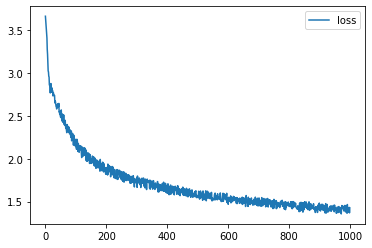

CPU times: user 5min 18s, sys: 3.66 s, total: 5min 22s
Wall time: 5min 21s


In [45]:
%%time
for i in range(1000):
    batch_ix = to_matrix(random.sample(chunks, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens),
                     actual_next_tokens.contiguous().view(-1))

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [84]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=100,
                    temperature=1.0):
    """
    The function generates text given a phrase of length of at least SEQ_LENGTH.
    :param seed_phrase: prefix characters, the sequence that the RNN 
    is asked to continue
    :param max_length: maximum output length, including seed_phrase length
    :param temperature: coefficient for sampling; higher temperature produces 
    more chaotic outputs, smaller temperature converges to the single 
    most likely output
    """
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase if there is any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    print(x_sequence[:, -1].shape, hid_state.shape)
    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=-1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [50]:
# An example of generated text.
print(generate_sample(char_rnn, max_length=500, temperature=0.5))

 but, for the sumble state,
  and the was in the with thee the true still of thy worth the some beauty the periest be the grace his mady thy beauty in my love thee,
    thou where the words on the shall to chalange?
  thou the wart unsell his show,
  the ear your self so sument that he rest,
  which in the world of that and they fire,
    the thou my love in fair fallers in my love beauty's beauty berown, and lives shall the full on the gerse the with the sweet and three remear say i of heart th


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [176]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=num_tokens,
                 num_units=64, num_layers=2, dropout=0.01):
        super(self.__class__, self).__init__()

        self.num_units = num_units
        self.num_layers = num_layers
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, num_units, batch_first=True,
                           num_layers=num_layers, dropout=dropout)
        self.hid_to_logits = nn.Linear(num_units, num_tokens)

    def forward(self, x, hid_state = None):
        if hid_state is None:
            h_seq, _ = self.rnn(self.emb(x))
            next_logits = self.hid_to_logits(h_seq)
            next_logp = F.log_softmax(next_logits, dim=-1)
            return next_logp
        else:
            h_seq, hid_state = self.rnn(self.emb(x), hid_state)
            next_logits = self.hid_to_logits(h_seq)
            next_logp = F.log_softmax(next_logits, dim=-1)
            return next_logp, hid_state
    
    def initial_state(self, batch_size):
        """Return RNN state before it processes the first input (h0)."""
        return torch.zeros(self.num_layers, batch_size, self.num_units), torch.zeros(self.num_layers, batch_size, self.num_units)

In [181]:
char_lstm = CharLSTM(num_layers=2, num_units=196, dropout=0.05)
opt = torch.optim.Adam(char_lstm.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
history = []
char_lstm

CharLSTM(
  (emb): Embedding(38, 38)
  (rnn): LSTM(38, 196, num_layers=2, batch_first=True, dropout=0.05)
  (hid_to_logits): Linear(in_features=196, out_features=38, bias=True)
)

Plot the loss function of the number of epochs. Does the final loss become better?

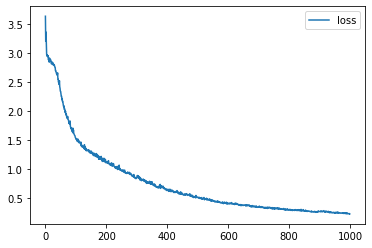

CPU times: user 1h 2min 42s, sys: 1min 5s, total: 1h 3min 47s
Wall time: 1h 3min 36s


In [182]:
%%time
char_lstm.train()
for i in range(1000):
    batch_ix = to_matrix(random.sample(chunks, 64))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = char_lstm(batch_ix)

    # compute loss
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                     batch_ix[:, 1:].contiguous().view(-1))

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label="loss")
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [138]:
def generate_sample_lstm(model, seed_phrase=' ', max_length=100,
                    temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)

    # feed the seed phrase if there is any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = model(x_sequence[:, i], hid_state)

    # start generating
    for i in range(max_length - len(seed_phrase)):
        logp_next, hid_state = model(x_sequence[..., -1:], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy().squeeze()
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=-1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [200]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(temp, ':')
    print(generate_sample_lstm(char_lstm, max_length=500, temperature=temp))

0.1 :
 with presence beauty with melays of laws,
  so my sun of your fair that your powerful reasons on that with their habes not then as when first, which makes thy face,
 on his cheek the treasure of thy amiss,
 like the defect,
 they are but dreams beguil'd,
 which lave and love's breath thou didst forsake me by looking of worth; for compile,
 or made his adjunct the world must die:
 the counterforial slave and love knows
 where thought,
 in their gazing spent?
 no marvel thence, be unthough their 
0.2 :
 with words must not is my love, to the ear that beauty where thou art more lovely and mutution die.
  the breast do thy worst to steal without think of thee, my loss is in my thought,
 to let us distill'd from limbeckss be travels, and wrow the sun;
 coral is partly lively new cruel and means comments o'er durs themelled fair, but for my love, and alive this self, that i am, there all men risent repart doth write for my love, knowsh thee in their right, where thou art the wind,
 or

The bigger temperature coffecient gets, the more chaotic output is. At temp = 2 many words are not even real. And, on the contrary, at the smallest values, words are more primitive and tend to repeat. So, it is better to choose this coefffecient somewhere in the middle

Final result is also better than with RNN.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [208]:
torch.save(char_lstm.state_dict(), 'Char_LSTM_Shakespeare.pth')

In [210]:
loaded_model = CharLSTM(num_layers=2, num_units=196, dropout=0.05)
loaded_model.load_state_dict(torch.load('Char_LSTM_Shakespeare.pth'))

<All keys matched successfully>

In [211]:
generate_sample_lstm(loaded_model, max_length=300, temperature=0.7)

"  thou couldst a vengue's rage,\n withor this blessed in thee aid, so be,\n making a couplement uside\n to neven to forty, which pader for my love, thy pine, make me love knows the joy for complicws can set o'er-hway that the parts on the firert,\n leaves out ornament was idolly veies with cruel; nor tr"

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)